# Breast Cancer Classification with 10-Fold Cross-Validation
This project details the development of a robust deep learning model to classify breast ultrasound images as benign or malignant.

For medical applications, a single accuracy score from one train/test split is not reliable. A "lucky" split could give a high score, while an "unlucky" one could give a low score.

To build a trustworthy and reliable model, this notebook uses 10-Fold Stratified Cross-Validation. This rigorous method involves training and testing the model 10 separate times, ensuring that every single image is used in the test set exactly once. This gives us a much more accurate and stable measure of the model's true performance.

## Project Goal
1. Integrate two separate public ultrasound datasets (Breast-Lesions-USG and BUSI) to create a larger, more diverse dataset.

2. Address significant class imbalance using oversampling of the minority class.

3. Implement a fine-tuned ResNet50 model with a custom classifier head for regularization.

4. Rigorously evaluate the model using 10-Fold Stratified Cross-Validation to get a reliable estimate of its performance on unseen data.

## The Validation Strategy: 10-Fold Cross-Validation
This is the most critical part of our project's methodology.

Instead of a single 80/20 train/test split, we use Stratified K-Fold Cross-Validation.

1. The entire dataset is shuffled and split into 10 equal-sized "folds".

2. We run 10 separate training "rounds".

3. In each round, 1 fold is held out as the test set, and the other 9 folds are used for training.

4. We average the 10 test scores to get a final, robust measure of our model's performance.

Stratified means that each fold has the same percentage of 'benign' and 'malignant' samples as the whole dataset, which is crucial for our imbalanced data.

This method ensures that our final metrics (Accuracy, Recall, F1-Score) are a reliable average, not the result of one lucky or unlucky random split.

# 1. Setup & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from albumentations import *


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import accuracy_score

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(12)
np.random.seed(12)
random.seed(12)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# 2.  Data Loading & Integration
To build a more robust model, we are combining two separate datasets. We will load each one into a pandas DataFrame, keeping only the image filepaths and their corresponding labels.

## Dataset 1: Breast-Lesions-USG

 [link text](https://www.cancerimagingarchive.net/collection/breast-lesions-usg/)

This dataset uses an Excel file to map image filenames to their clinical data.



In [ ]:
data_dir1 = '/content/drive/My Drive/project/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions_USG-images_and_masks'
file_path1 = '/content/drive/My Drive/project/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx'


In [ ]:
data1=pd.read_excel(file_path1)
data1 = data1[data1['Classification'] != 'normal']
data1.head()

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
1,2,case002.png,case002_tumor.png,NaN,0.006462,not available,homogeneous: fat,not available,not available,oval,...,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,4b,confirmed by biopsy,Intramammary lymph node,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant


In [ ]:
# Create a DataFrame1 with images and labels
labels1 = data1['Classification']
Image_filename1 = data1['Image_filename']
image_paths1 = []

for image_name in Image_filename1:
    file_path1 = os.path.join(data_dir1 , image_name)
    image_paths1.append(file_path1)

df1 = pd.DataFrame({'filepaths': image_paths1, 'labels': labels1})

print(df1.shape)


(252, 2)


## Dataset 2: BUSI (Dataset_BUSI_with_GT)
[link text](https://www.kaggle.com/datasets/anaselmasry/datasetbusiwithgt)





In [ ]:
data_dir2 = '/content/drive/My Drive/project/Dataset_BUSI_with_GT'

In [ ]:
# Create a DataFrame2 with images and labels
image_paths2 = []
labels2 = []
for folder in os.listdir(data_dir2):
    folder_path2 = os.path.join(data_dir2 , folder)

    if not os.path.isdir(folder_path2):
        continue

    for file in os.listdir(folder_path2):
        if "_mask" not in file:
            file_path2 = os.path.join(folder_path2 , file)
            image_paths2.append(file_path2)
            labels2.append(folder)

df2 = pd.DataFrame({'filepaths': image_paths2, 'labels': labels2})

df2['labels'] = df2['labels'].str.lower()
df2 = df2[df2['labels'] != 'normal']

print(df2.shape)

(647, 2)


# 3. Exploratory Data Analysis (EDA)
Let's analyze the class distribution of our final training set.

In [ ]:
# Combine both datasets
combined_df = pd.concat([df1, df2], ignore_index=True)
print(f"Combined dataset size: {len(combined_df)}")

# Display class distribution
class_counts = combined_df['labels'].value_counts()
print("Class distribution:")
print(class_counts)


Combined dataset size: 899
Class distribution:
labels
benign       591
malignant    308
Name: count, dtype: int64


- EDA Finding: Significant Class Imbalance

The plot clearly shows a severe class imbalance. The 'benign' class has far more samples than the 'malignant' class.

Why this is a problem: A model trained on this data would become "lazy" and biased. It could achieve high accuracy by simply guessing 'benign' most of the time. This would make it useless in a clinical setting, as it would miss most of the malignant (cancerous) cases.

Our Strategy: We will use oversampling on the minority class ('malignant'). We will create new, augmented versions of the malignant images and add them to the training set to create a balanced dataset.

# 4. Core Components & Model Architecture
Here, we define all the building blocks for our model and training pipeline.

### **The Custom Dataset**

A standard PyTorch Dataset class to load images from the filepaths in our DataFrame and apply transformations.

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(combined_df['labels'].unique())


In [ ]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepaths']
        label = self.dataframe.loc[idx, 'labels']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label_tensor = torch.tensor(int(label == 'malignant'), dtype=torch.long)
        return image, label_tensor


### **EarlyStopping**
A utility class to monitor validation loss. It stops the training if the model doesn't improve for 10 epochs, and it automatically restores the model weights from the best epoch. This prevents overfitting.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f'Early stopping triggered after {self.patience} epochs.')
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

### **The Classifier Head**
We replace the final layer of the pre-trained ResNet50 with this custom ClassifierHead. It includes BatchNorm and Dropout layers, which are powerful regularization techniques to help prevent overfitting.

In [ ]:
# Classifier Head
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ClassifierHead, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.head(x)

### **The Model: ResNet50 with Fine-Tuning**
We use a ResNet50 model pre-trained on ImageNet. This is called transfer learning.

1. We load the model with its pre-trained weights.

2. We freeze all the layers.

3. We unfreeze only the last 50 residual blocks. This allows the model to fine-tune its high-level feature detectors for our specific ultrasound images, while still leveraging the basic features (edges, textures) it learned from ImageNet.

4. We attach our custom ClassifierHead.

In [ ]:
def create_model():
    """Create and configure the ResNet34 model"""
    model = timm.create_model('resnet50', pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Collect residual blocks from all layers
    residual_blocks = []
    for name in ['layer1', 'layer2', 'layer3', 'layer4']:
        layer = getattr(model, name)
        for block in layer:
            residual_blocks.append(block)

    # Unfreeze last 50 blocks
    for block in residual_blocks[-50:]:
        for param in block.parameters():
            param.requires_grad = True


    # Replace the classifier
    model.fc = ClassifierHead(model.fc.in_features, NUM_CLASSES)

    return model


### **Calculate Dataset Stats**
This function calculates the mean and standard deviation of the training dataset. (Note: We are using ImageNet stats in the final code, which is a common and effective practice for transfer learning).

In [ ]:
def calculate_mean_std(dataframe):
    """Calculate mean and std for normalization"""
    basic_transform = Compose([
        Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        ToTensorV2()
    ])

    dataset = CustomDataset(dataframe, transform=basic_transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_batches = 0

    for images, _ in loader:
        images = images.float() / 255.0
        mean += images.mean([0, 2, 3])
        std += images.std([0, 2, 3])
        num_batches += 1

    mean /= num_batches
    std /= num_batches

    return mean, std

### **Oversampling**
This function takes the training DataFrame for a fold, isolates the 'malignant' samples, and creates new augmented versions of them. It then adds these new samples to the training set to create a balanced DataFrame.

This is done inside the training loop for each fold. This is critical to prevent data leakage, ensuring that no augmented data from the training set is ever seen by the validation or test sets.

In [ ]:
def augment_malignant_data(train_df, augment_transform):
    """Augment malignant samples to balance the dataset"""
    malignant_df = train_df[train_df['labels'] == 'malignant']

    if len(malignant_df) == 0:
        return train_df

    # Create augmented malignant dataset
    malignant_dataset = CustomDataset(malignant_df, transform=augment_transform)
    malignant_loader = DataLoader(malignant_dataset, batch_size=len(malignant_dataset), shuffle=False)

    # Generate augmented samples
    augmented_images, augmented_labels = next(iter(malignant_loader))

    # Create new DataFrame for augmented samples
    augmented_df = pd.DataFrame({
        'filepaths': malignant_df['filepaths'].values,
        'labels': ['malignant'] * len(augmented_images)
    })

    # Combine original and augmented data
    balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

    return balanced_train_df


### **Training**
This is the main training and validation loop for a single fold.

1. Takes the train and validation DataFrames.

2. Applies augmentations and balancing to the train data.

3. Initializes the model, optimizer, and loss function.

4. Loops for a set number of epochs, performing training and validation.

5. Uses EarlyStopping to prevent overfitting.

6. Returns the trained model and its history.

In [ ]:
def train_fold(train_df, val_df, fold_num, mean, std):
    """Train model for one fold"""
    print(f"\n--- Fold {fold_num} ---")
    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

    # Augmentation transforms
    augment_transform = Compose([
            Affine(scale=(0.8, 1.2), translate_percent=(0.2, 0.2), rotate=(-40, 40), p=0.1),
            # HorizontalFlip(p=0.1),
            # VerticalFlip(p=0.1),
            RandomRotate90(p=0.5),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            # HueSaturationValue(p=0.5),
            # RandomCrop(width=164, height=164, p=0.5),
            Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
            ToTensorV2()
    ])

    # Training transforms
    train_transform = Compose([
        Resize(*IMAGE_SIZE),
        HorizontalFlip(p=0.1),
        VerticalFlip(p=0.1),
        RandomRotate90(p=0.1),
        CLAHE(),
        GaussNoise(p=0.5),
        Normalize(mean, std),
        ToTensorV2()
    ])

    # Validation transforms
    val_transform = Compose([
        Resize(*IMAGE_SIZE),
        Normalize(mean, std),
        ToTensorV2()
    ])

    # Balance the training data
    balanced_train_df = augment_malignant_data(train_df, augment_transform)

    print(f"Balanced train size: {len(balanced_train_df)}")
    print("Class distribution after balancing:")
    print(balanced_train_df['labels'].value_counts())

    # Create datasets and dataloaders
    train_dataset = CustomDataset(balanced_train_df, transform=train_transform)
    val_dataset = CustomDataset(val_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Create model
    model = create_model()
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6)

    # Early stopping
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    # Training loop
    epochs = 30
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step(val_loss)

        if early_stopping(val_loss, model):
            print(f"Stopping early at epoch {epoch+1}")
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies


### **Evaluating One Fold**
This function takes the final trained model from a fold and evaluates it on the held-out test set. It calculates all the critical metrics for our analysis.

In [ ]:
def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    test_correct = 0
    test_total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total

    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')

    return test_accuracy, test_loss, f1, recall, precision, all_preds, all_labels

#5. 10-Fold Cross-Validation
This is the main execution function. It orchestrates the entire K-Fold process:

1. Sets up the 10 StratifiedKFold splits.

2. Uses ImageNet stats for normalization (a robust practice for transfer learning).

3. Loops 10 times (once for each fold).

4. In each loop, it splits the data, calls train_fold, and then calls evaluate_model on the test fold.

5. It collects all results and saves the model from each fold.

In [ ]:
# Main 10-fold cross-validation
def run_cross_validation():
    # Calculate mean and std for normalization
    # print("Calculating dataset statistics...")
    # mean, std = calculate_mean_std(combined_df)
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")

    # Initialize 10-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Store results for each fold
    fold_results = []
    all_histories = []

    # Convert labels to numeric for stratification
    y = (combined_df['labels'] == 'malignant').astype(int)

    for fold, (train_idx, test_idx) in enumerate(kfold.split(combined_df, y)):
        # Split data into train and test for this fold
        train_df = combined_df.iloc[train_idx].reset_index(drop=True)
        test_df = combined_df.iloc[test_idx].reset_index(drop=True)

        # split train into train and validation (80:20)
        train_df, val_df = train_test_split(
            train_df,
            test_size=0.2,
            stratify=train_df['labels'],
            random_state=42
        )

        # Train model for this fold
        model, train_losses, val_losses, train_accuracies, val_accuracies = train_fold(
            train_df, val_df, fold + 1, mean, std
        )

        # Test transform
        test_transform = Compose([
            Resize(*IMAGE_SIZE),
            Normalize(mean, std),
            ToTensorV2()
        ])

        # Create test dataset and loader
        test_dataset = CustomDataset(test_df, transform=test_transform)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Evaluate model
        test_accuracy, test_loss, f1, recall, precision, all_preds, all_labels = evaluate_model(model, test_loader)

        # Store results
        fold_results.append({
            'fold': fold + 1,
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'predictions': all_preds,
            'labels': all_labels
        })

        all_histories.append({
            'fold': fold + 1,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        })

        print(f"Fold {fold + 1} Results:")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print("-" * 50)

        # Save model for this fold
        torch.save(model.state_dict(), f'model_fold_{fold + 1}.pth')

    return fold_results, all_histories


# 6. Results & Analysis
Now we aggregate and visualize the results from all 10 folds.

Starting 10-fold cross-validation...
Mean: [0.485, 0.456, 0.406]
Standard Deviation: [0.229, 0.224, 0.225]

--- Fold 1 ---
Train size: 647, Val size: 162
Balanced train size: 869
Class distribution after balancing:
labels
malignant    444
benign       425
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch [1/30], Train Loss: 0.7329, Train Acc: 52.13%, Val Loss: 0.6782, Val Acc: 65.43%
Epoch [6/30], Train Loss: 0.4732, Train Acc: 77.45%, Val Loss: 0.4182, Val Acc: 80.86%
Epoch [11/30], Train Loss: 0.3877, Train Acc: 82.62%, Val Loss: 0.3756, Val Acc: 90.74%
Epoch [16/30], Train Loss: 0.2557, Train Acc: 87.92%, Val Loss: 0.3921, Val Acc: 88.27%
Epoch [21/30], Train Loss: 0.2130, Train Acc: 91.71%, Val Loss: 0.3942, Val Acc: 89.51%
Epoch [26/30], Train Loss: 0.2086, Train Acc: 91.48%, Val Loss: 0.4398, Val Acc: 90.74%
Epoch [30/30], Train Loss: 0.1716, Train Acc: 93.90%, Val Loss: 0.4479, Val Acc: 87.65%
Fold 1 Results:
Test Accuracy: 75.56%
Test Loss: 0.6533
F1 Score: 0.6207
Recall: 0.6000
Precision: 0.6429
--------------------------------------------------

--- Fold 2 ---
Train size: 647, Val size: 162
Balanced train size: 869
Class distribution after balancing:
labels
malignant    444
benign       425
Name: count, dtype: int64
Epoch [1/30], Train Loss: 0.7187, Train Acc: 54.09%, V

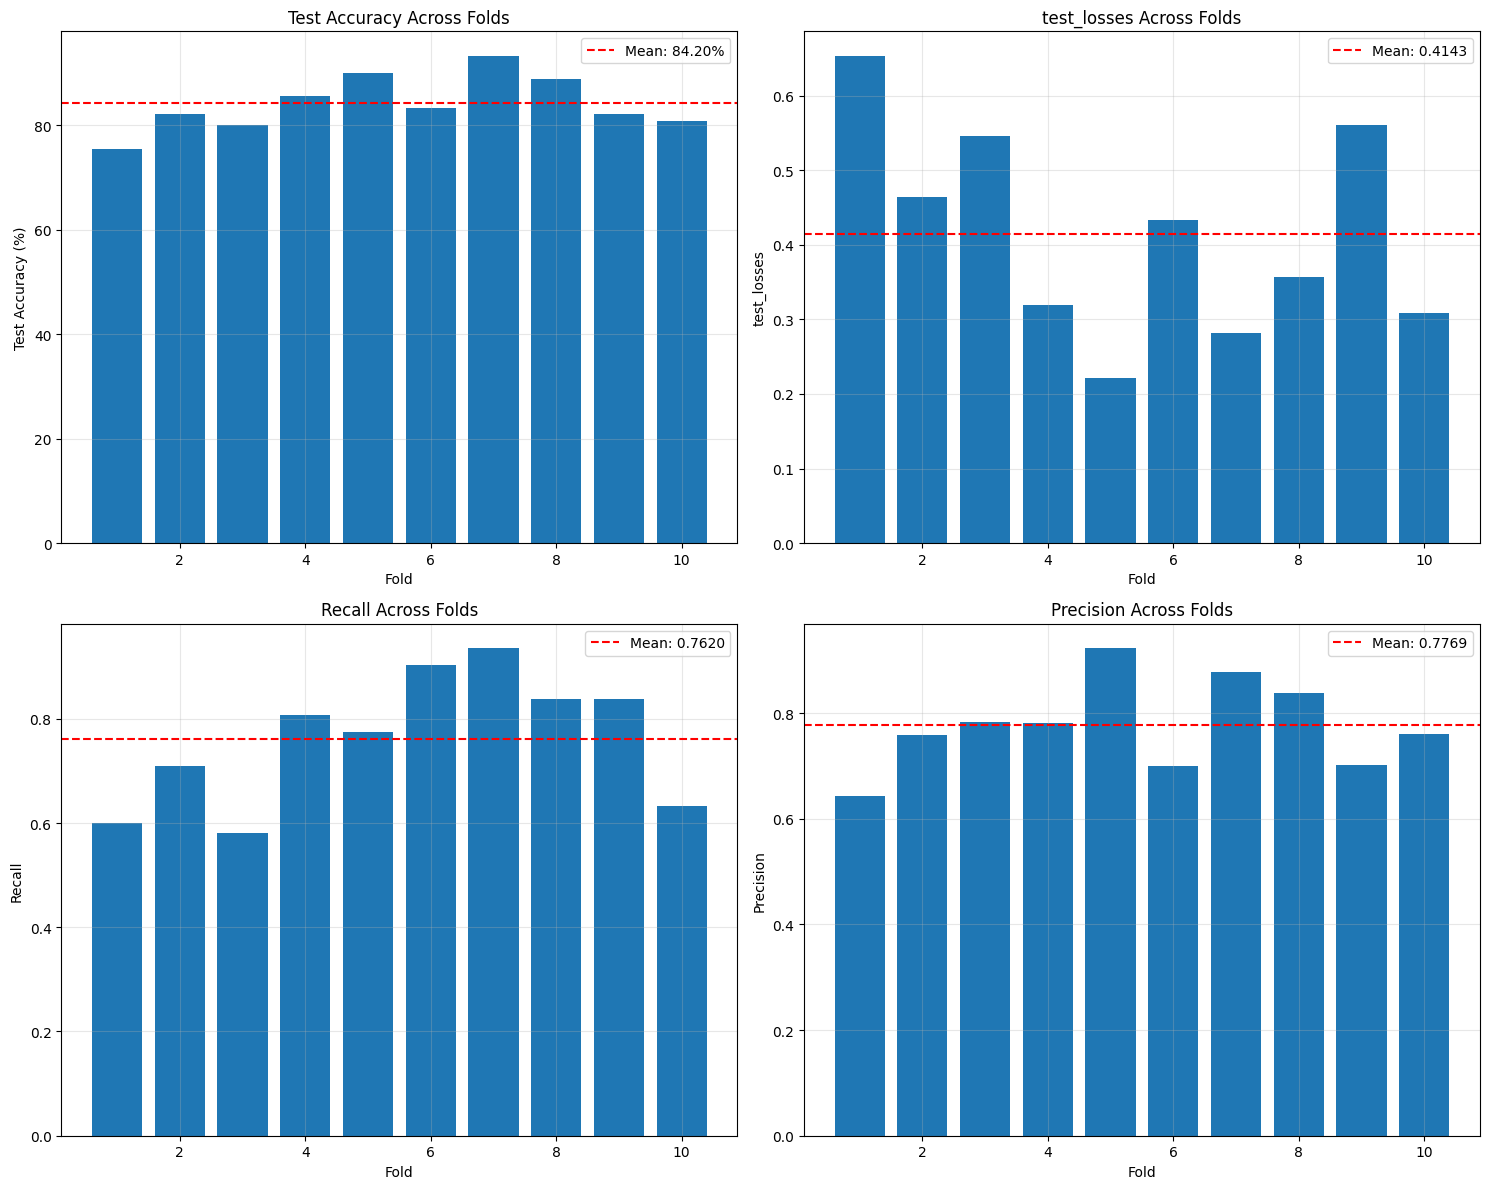

In [ ]:
# Run the cross-validation
print("Starting 10-fold cross-validation...")
fold_results, all_histories = run_cross_validation()

# Calculate overall statistics
accuracies = [result['test_accuracy'] for result in fold_results]
test_losses = [result['test_loss'] for result in fold_results]
f1_scores = [result['f1_score'] for result in fold_results]
recalls = [result['recall'] for result in fold_results]
precisions = [result['precision'] for result in fold_results]

print("\n" + "="*60)
print("10-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
print(f"Mean Test Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
print(f"Mean Test Loss: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")

# Detailed results for each fold
print("\nDetailed Results by Fold:")
for result in fold_results:
    print(f"Fold {result['fold']}: Acc={result['test_accuracy']:.2f}%, loss={result['test_loss']:.4f}% , F1={result['f1_score']:.4f}, Recall={result['recall']:.4f}, Precision={result['precision']:.4f},")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy across folds
axes[0, 0].bar(range(1, 11), accuracies)
axes[0, 0].axhline(y=np.mean(accuracies), color='r', linestyle='--', label=f'Mean: {np.mean(accuracies):.2f}%')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Test Accuracy (%)')
axes[0, 0].set_title('Test Accuracy Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: loss across folds
axes[0, 1].bar(range(1, 11), test_losses)
axes[0, 1].axhline(y=np.mean(test_losses), color='r', linestyle='--', label=f'Mean: {np.mean(test_losses):.4f}')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('test_losses')
axes[0, 1].set_title('test_losses Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Recall across folds
axes[1, 0].bar(range(1, 11), recalls)
axes[1, 0].axhline(y=np.mean(recalls), color='r', linestyle='--', label=f'Mean: {np.mean(recalls):.4f}')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall Across Folds')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Precision across folds
axes[1, 1].bar(range(1, 11), precisions)
axes[1, 1].axhline(y=np.mean(precisions), color='r', linestyle='--', label=f'Mean: {np.mean(precisions):.4f}')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision Across Folds')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Performance Per-Fold Visualization**

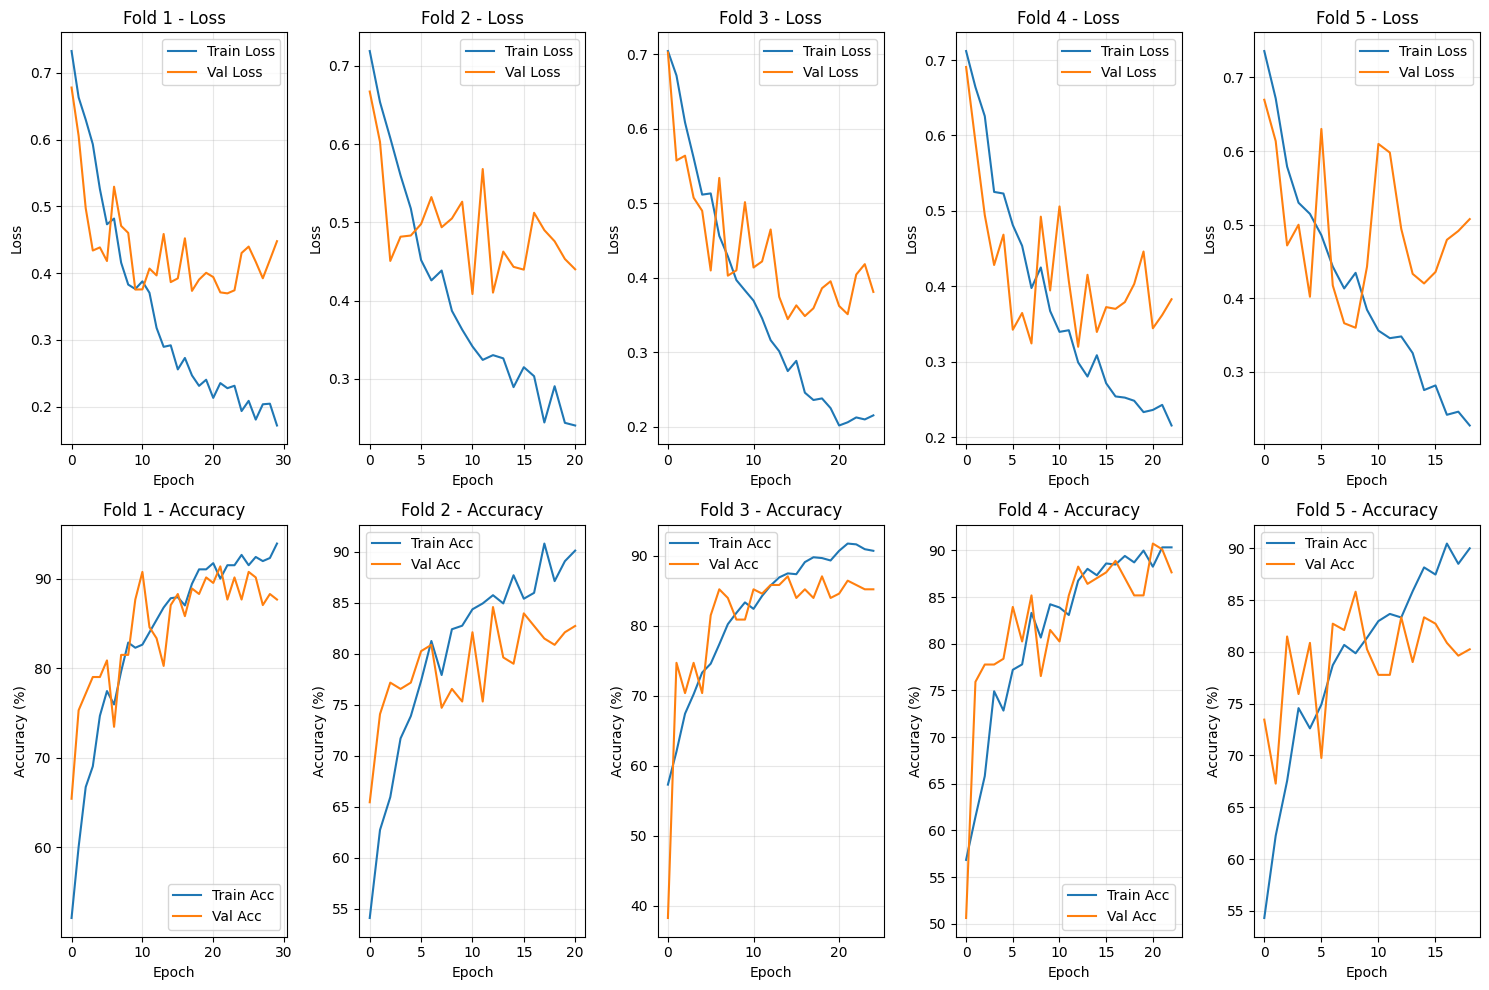

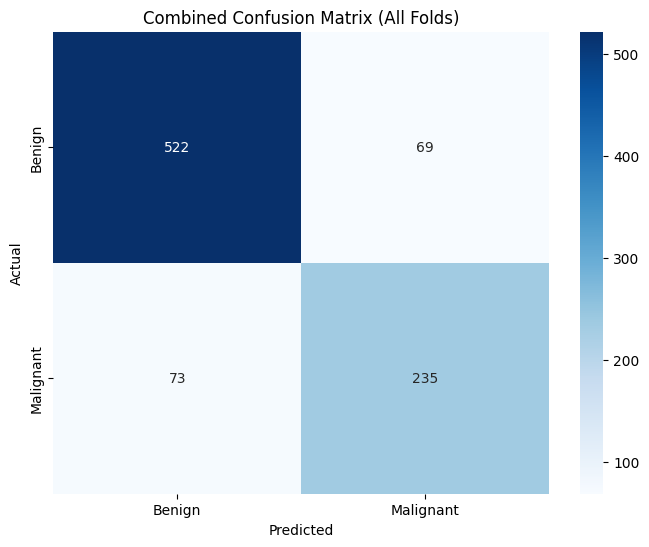


Combined Confusion Matrix:
[[522  69]
 [ 73 235]]


In [ ]:
# Plot training histories for a few folds
plt.figure(figsize=(15, 10))
for i in range(min(5, len(all_histories))):  # Show first 5 folds
    history = all_histories[i]

    # Loss plot
    plt.subplot(2, 5, i + 1)
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {history["fold"]} - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy plot
    plt.subplot(2, 5, i + 6)
    plt.plot(history['train_accuracies'], label='Train Acc')
    plt.plot(history['val_accuracies'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Fold {history["fold"]} - Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Combined confusion matrix across all folds
all_predictions = []
all_true_labels = []
for result in fold_results:
    all_predictions.extend(result['predictions'])
    all_true_labels.extend(result['labels'])

cm_combined = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix (All Folds)')
plt.show()

print("\nCombined Confusion Matrix:")
print(cm_combined)